<a href="https://colab.research.google.com/github/ropholuo/ESE546-Intro-to-Deep-learning/blob/main/Group_99_ESE546_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import scipy.sparse as sp
import torch
import math
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module
import argparse
import torch.optim as optim
import torch.sparse as sparse
import matplotlib.pyplot as plt
from torch.nn import Sequential as Seq
from sklearn.model_selection import KFold

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Load Data

The data form in cora.content:

2708 x 1433

Labels: 8 categories are included in the cora.content dataset: 

'Case_Based', 'Genetic_Algorithms', 'Neural_Networks', 'Probabilistic_Methods', 'Reinforcement_Learning', 'Rule_Learning', 'Theory'


The data form in cora.cites: 

\<Paper_ID_1> \<Paper_ID_2> 

The first one was cited by the second paper



In [ ]:
def encode_onehot(labels):
  classes = set(labels) 
  # One-hot encoding labels
  labels_dict = {c: np.identity(len(classes))[i, :] for i, c in 
                  enumerate(classes)}  
  # construct the label matrix   
  labels_onehot = np.array(list(map(labels_dict.get, labels)),  
                            dtype=np.int32)
  return labels_onehot

def normalize(matrix):
  r_rec = np.power(np.array(matrix.sum(1)) , -1).flatten()  
  # avoid infinity reciprocal
  r_rec[np.isinf(r_rec)] = 0.  
  r_mat_rec = sp.diags(r_rec)
  matrix = r_mat_rec.dot(matrix)
  return matrix

jinhui_path = "/content/gdrive/MyDrive/Colab Notebooks/ESE546/project/cora/"
jasper_path = "/content/gdrive/MyDrive/ESE546_Project/"

def load_data(path=jinhui_path, dataset="cora"):
  # get paper contents(features) and labels
  # 1433 features for each paper
  index = np.genfromtxt("{}{}.content".format(path, dataset),dtype=np.dtype(str))
  features = sp.csr_matrix(index[:, 1:-1], dtype=np.float32)  
  labels = encode_onehot(index[:, -1])
  
  # construct the graph
  # idx_map: (paper_id, index)
  idx = np.array(index[:, 0], dtype=np.int32)
  idx_map = {j: i for i, j in enumerate(idx)}
  edges_ = np.genfromtxt("{}{}.cites".format(path, dataset),dtype=np.int32)
  # convert the paper_id into index
  edges = np.array(list(map(idx_map.get, edges_.flatten())), 
                     dtype=np.int32).reshape(edges_.shape)
                     
  # construct adjacent matrix(COO types)
  # 2708 x 2708
  adj = sp.coo_matrix((np.ones(edges.shape[0]), (edges[:, 0], edges[:, 1])),  
                        shape=(labels.shape[0], labels.shape[0]),
                        dtype=np.float32)
  
  features = normalize(features)
  adj = normalize(adj + sp.eye(adj.shape[0]))

  idx_train = range(1400)
  idx_val = range(1400, 1600)
  idx_test = range(1600, 2000)

  features = torch.FloatTensor(np.array(features.todense())) 
  # convert back
  labels = torch.LongTensor(np.where(labels)[1])

  # convert adj matrix into tensor form 
  sparse_mx = adj.tocoo().astype(np.float32)
  indices = torch.from_numpy(np.vstack((sparse_mx.row, sparse_mx.col)).astype(np.int64))
  values = torch.from_numpy(sparse_mx.data)
  shape = torch.Size(sparse_mx.shape)
  adj =  torch.sparse.FloatTensor(indices, values, shape)

  # idx_train = torch.LongTensor(idx_train)
  # idx_val = torch.LongTensor(idx_val)
  # idx_test = torch.LongTensor(idx_test)
  # return adj, features, labels, idx_train, idx_val, idx_test
  return adj, features, labels
 


# General Model

## GraphConvolution

In [ ]:
class GraphConvolution(Module):
  def __init__(self, feature_in, feature_out, bias=True):
    super(GraphConvolution, self).__init__()
    self.feature_in = feature_in
    self.feature_out = feature_out
    self.weight = Parameter(torch.FloatTensor(feature_in, feature_out))
    if bias:
      self.bias = Parameter(torch.FloatTensor(feature_out))
    else:
      self.register_parameter('bias', None)
    self.reset()

  def reset(self):
    # random select tensor value for the weights
    stdv = 1. / math.sqrt(self.weight.size(1))
    self.weight.data.uniform_(-stdv, stdv)  
    if self.bias is not None:
      self.bias.data.uniform_(-stdv, stdv)

  def forward(self, input, adj):
    '''
    A*X*W
    '''
    output = sparse.mm(adj, torch.mm(input, self.weight))
    if self.bias is not None:
      return output + self.bias
    else:
      return output


## GCN class

Three layers GCN model

ReLu(layer1) -> Dropout -> Softmax(layer2) 


In [ ]:
class GCN(nn.Module):
  def __init__(self, n_feature, n_hidden, n_class, dropout): 
    super(GCN, self).__init__() 
    self.layer1 = GraphConvolution(n_feature, n_hidden)   
    self.layer2 = GraphConvolution(n_hidden, n_class) 
    self.dropout = dropout

  def forward(self, x, adj):
    x = F.relu(self.layer1(x, adj)) 
    x = F.dropout(x, self.dropout, training=self.training)
    x = self.layer2(x, adj)
    return F.log_softmax(x, dim=1)

## GCN Training

Parameter Setting

In [ ]:
parser = argparse.ArgumentParser()
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='Cuda Status')
parser.add_argument('--seed', type=int, default=42, help='Random seed.')
parser.add_argument('--epochs', type=int, default=200,
                    help='Number of epochs.')
parser.add_argument('--lr', type=float, default=0.01,
                    help='Learning rate')
parser.add_argument('--weight_decay', type=float, default=5e-4,
                    help='L2 norm')
parser.add_argument('--hidden', type=int, default=16,
                    help='Number of hidden nodes..')
parser.add_argument('--dropout', type=float, default=0.5,
                    help='Dropout rate')
args = parser.parse_args(args=[])

args.cuda = not args.no_cuda and torch.cuda.is_available()
np.random.seed(args.seed)
torch.manual_seed(args.seed)   
if args.cuda:
    torch.cuda.manual_seed(args.seed)

Load Data 

In [ ]:
# adj, features, labels, idx_train, idx_val, idx_test = load_data()
adj, features, labels = load_data()

 Setup model and optimizer

In [ ]:
GCN_model = GCN(n_feature=features.shape[1],
        n_hidden=args.hidden,
        n_class=labels.max().item() + 1,
        dropout=args.dropout)
optimizer = optim.Adam(GCN_model.parameters(),lr=args.lr,
                       weight_decay=args.weight_decay)
if args.cuda:
  GCN_model.cuda()  
  features = features.cuda()
  adj = adj.cuda()
  labels = labels.cuda()
  # idx_train = idx_train.cuda()
  # idx_val = idx_val.cuda()
  # idx_test = idx_test.cuda()



### Training Process

In [ ]:
def accuracy(output, labels):
  predict = output.max(1)[1].type_as(labels)
  correct = predict.eq(labels).double()
  correct = correct.sum()
  return correct / len(labels)

In [ ]:
def GCN_train(epochs):
  # get index for train and val
  # idx_train_val = range(2500)
  kf = KFold(n_splits=10,shuffle = True)
  index = list(range(2500))
  # idx_test = list(range(2500, 2700))
  # idx_test = torch.LongTensor(idx_test).cuda()
  list_train_loss, list_acc_train, list_val_loss, list_acc_val = [], [], [], []
  for epoch in range(epochs):
    for idx_train, idx_val in kf.split(index):
      lst_loss_train, lst_acc_train, lst_acc_val, lst_loss_val =[],[],[],[] 
      idx_train = torch.LongTensor(idx_train).cuda()
      idx_val = torch.LongTensor(idx_val).cuda()

      GCN_model.train()
      optimizer.zero_grad()
      output = GCN_model(features, adj)
      loss_train = F.nll_loss(output[idx_train], labels[idx_train])
      acc_train = accuracy(output[idx_train], labels[idx_train])
      # Back propogation
      loss_train.backward()  
      optimizer.step()  

      GCN_model.eval()
      output = GCN_model(features, adj)
      loss_val = F.nll_loss(output[idx_val], labels[idx_val]) 
      acc_val = accuracy(output[idx_val], labels[idx_val])

      
      lst_acc_train.append(acc_train.item())
      lst_acc_val.append(acc_val.item())
      lst_loss_train.append(loss_train.item())
      lst_loss_val.append(loss_val.item())

     
    
    print('Epoch: {:04d}'.format(epoch+1),
          'loss_train: {:.4f}'.format(np.mean(lst_loss_train)),
          'acc_train: {:.4f}'.format(np.mean(lst_acc_train)),
          'loss_val: {:.4f}'.format(np.mean(lst_loss_val)),
          'acc_val: {:.4f}'.format(np.mean(lst_acc_val)))

    list_train_loss.append(np.mean(lst_loss_train))
    list_acc_train.append(np.mean(lst_acc_train))
    list_val_loss.append(np.mean(lst_loss_val))
    list_acc_val.append(np.mean(lst_acc_val))

  return list_train_loss, list_acc_train, list_val_loss, list_acc_val

In [ ]:
gcn_train_loss, gcn_acc_train, gcn_val_loss, gcn_acc_val = GCN_train(400)
print("Optimization Finished!")

Epoch: 0001 loss_train: 1.8965 acc_train: 0.2773 loss_val: 1.8845 acc_val: 0.2840
Epoch: 0002 loss_train: 1.8174 acc_train: 0.2924 loss_val: 1.7334 acc_val: 0.3600
Epoch: 0003 loss_train: 1.7479 acc_train: 0.3018 loss_val: 1.7486 acc_val: 0.3000
Epoch: 0004 loss_train: 1.6782 acc_train: 0.3156 loss_val: 1.6727 acc_val: 0.2720
Epoch: 0005 loss_train: 1.5913 acc_train: 0.3480 loss_val: 1.5963 acc_val: 0.3120
Epoch: 0006 loss_train: 1.5000 acc_train: 0.4436 loss_val: 1.4289 acc_val: 0.5120
Epoch: 0007 loss_train: 1.3892 acc_train: 0.5347 loss_val: 1.3017 acc_val: 0.6360
Epoch: 0008 loss_train: 1.2712 acc_train: 0.6022 loss_val: 1.2129 acc_val: 0.6920
Epoch: 0009 loss_train: 1.1743 acc_train: 0.6591 loss_val: 1.0842 acc_val: 0.7640
Epoch: 0010 loss_train: 1.0933 acc_train: 0.6858 loss_val: 0.9487 acc_val: 0.8000
Epoch: 0011 loss_train: 0.9968 acc_train: 0.7191 loss_val: 0.8546 acc_val: 0.8160
Epoch: 0012 loss_train: 0.9387 acc_train: 0.7396 loss_val: 0.7587 acc_val: 0.8560
Epoch: 0013 loss

### Draw out

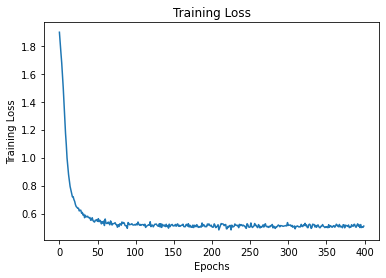

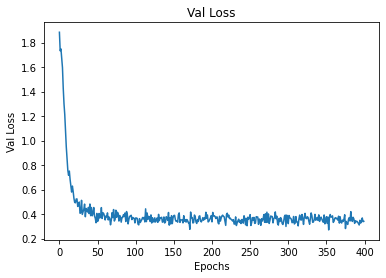

In [ ]:
plt.plot(range(len(gcn_train_loss)), gcn_train_loss)
plt.xlabel("Epochs")
plt.ylabel('Training Loss')
plt.title("Training Loss")
plt.show()

plt.plot(range(len(gcn_val_loss)), gcn_val_loss)
plt.xlabel("Epochs")
plt.ylabel('Val Loss')
plt.title("Val Loss")
plt.show()

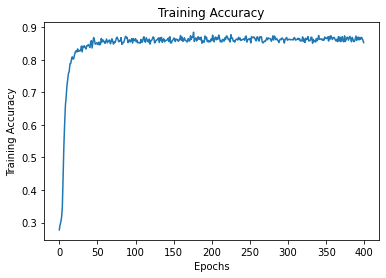

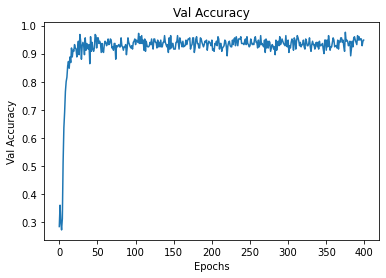

In [ ]:
plt.plot(range(len(gcn_acc_train)), gcn_acc_train)
plt.xlabel("Epochs")
plt.ylabel('Training Accuracy')
plt.title("Training Accuracy")
plt.show()

plt.plot(range(len(gcn_acc_val)), gcn_acc_val)
plt.xlabel("Epochs")
plt.ylabel('Val Accuracy')
plt.title("Val Accuracy")
plt.show()

## GCN Test

### Testing Process

In [ ]:
def test():
  idx_test = list(range(2500, 2700))
  idx_test = torch.LongTensor(idx_test).cuda()
  GCN_model.eval()
  output = GCN_model(features, adj)
  loss_test = F.nll_loss(output[idx_test], labels[idx_test])
  acc_test = accuracy(output[idx_test], labels[idx_test])
  print("Test set results:",
        "loss= {:.4f}".format(loss_test.item()),
        "accuracy= {:.4f}".format(acc_test.item()))
test()

Test set results: loss= 0.6177 accuracy= 0.8400


# LightGCN

## Load Dataset

In [ ]:
adj, features, labels = load_data()

## Main Structure

In [ ]:
class LightGCN(nn.Module):
  def __init__(self, n_feature, n_hidden, n_class, dropout): 
    super(LightGCN, self).__init__() 
    self.layer1 = GraphConvolution(n_feature, n_hidden)   
    self.layer2 = GraphConvolution(n_hidden, n_class) 
    self.dropout = dropout

  def forward(self, x, adj):
    x = self.layer1(x, adj)
    x = F.dropout(x, self.dropout, training=self.training)
    x = self.layer2(x, adj)
    return F.log_softmax(x, dim=1)

## Parameter Setting

In [ ]:
parser = argparse.ArgumentParser()
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='Cuda Status')
parser.add_argument('--seed', type=int, default=42, help='Random seed.')
parser.add_argument('--epochs', type=int, default=200,
                    help='Number of epochs.')
parser.add_argument('--lr', type=float, default=0.01,
                    help='Learning rate')
parser.add_argument('--weight_decay', type=float, default=5e-4,
                    help='L2 norm')
parser.add_argument('--hidden', type=int, default=16,
                    help='Number of hidden nodes..')
parser.add_argument('--dropout', type=float, default=0.5,
                    help='Dropout rate')
args = parser.parse_args(args=[])

args.cuda = not args.no_cuda and torch.cuda.is_available()
np.random.seed(args.seed)
torch.manual_seed(args.seed)   
if args.cuda:
    torch.cuda.manual_seed(args.seed)

In [ ]:
LightGCN_model = LightGCN(n_feature=features.shape[1],
        n_hidden=args.hidden,
        n_class=labels.max().item() + 1,
        dropout=args.dropout)
optimizer = optim.Adam(LightGCN_model.parameters(),lr=args.lr,
                       weight_decay=args.weight_decay)
if args.cuda:
  LightGCN_model.cuda()  
  features = features.cuda()
  adj = adj.cuda()
  labels = labels.cuda()

## LightGCN training

In [ ]:
def train(epoch):
  # get index for train and val
  # idx_train_val = range(2500)
  kf = KFold(n_splits=10,shuffle = True)
  index = list(range(2500))
  # idx_test = list(range(2500, 2700))
  # idx_test = torch.LongTensor(idx_test).cuda()
  list_train_loss, list_acc_train, list_val_loss, list_acc_val = [], [], [], []
  for epoch in range(args.epochs):
    for idx_train, idx_val in kf.split(index):
      lst_loss_train, lst_acc_train, lst_acc_val, lst_loss_val =[],[],[],[] 
      idx_train = torch.LongTensor(idx_train).cuda()
      idx_val = torch.LongTensor(idx_val).cuda()

      LightGCN_model.train()
      optimizer.zero_grad()
      output = LightGCN_model(features, adj)
      loss_train = F.nll_loss(output[idx_train], labels[idx_train])
      acc_train = accuracy(output[idx_train], labels[idx_train])
      # Back propogation
      # loss_train.backward()  
      optimizer.step()  

      LightGCN_model.eval()
      output = LightGCN_model(features, adj)
      loss_val = F.nll_loss(output[idx_val], labels[idx_val]) 
      acc_val = accuracy(output[idx_val], labels[idx_val])

      lst_acc_train.append(acc_train.item())
      lst_acc_val.append(acc_val.item())
      lst_loss_train.append(loss_train.item())
      lst_loss_val.append(loss_val.item())

     
    
    print('Epoch: {:04d}'.format(epoch+1),
          'loss_train: {:.4f}'.format(np.mean(lst_loss_train)),
          'acc_train: {:.4f}'.format(np.mean(lst_acc_train)),
          'loss_val: {:.4f}'.format(np.mean(lst_loss_val)),
          'acc_val: {:.4f}'.format(np.mean(lst_acc_val)))

    list_train_loss.append(np.mean(lst_loss_train))
    list_acc_train.append(np.mean(lst_acc_train))
    list_val_loss.append(np.mean(lst_loss_val))
    list_acc_val.append(np.mean(lst_acc_val))

  return list_train_loss, list_acc_train, list_val_loss, list_acc_val

In [ ]:
light_train_loss, light_acc_train, light_val_loss, light_acc_val = train(args.epochs)
print("Optimization Finished!")

Epoch: 0001 loss_train: 1.9857 acc_train: 0.1040 loss_val: 1.9678 acc_val: 0.1160
Epoch: 0002 loss_train: 1.9814 acc_train: 0.0969 loss_val: 1.9730 acc_val: 0.0760
Epoch: 0003 loss_train: 1.9770 acc_train: 0.1058 loss_val: 1.9700 acc_val: 0.0880
Epoch: 0004 loss_train: 1.9802 acc_train: 0.0951 loss_val: 1.9804 acc_val: 0.0920
Epoch: 0005 loss_train: 1.9771 acc_train: 0.1067 loss_val: 1.9592 acc_val: 0.1240
Epoch: 0006 loss_train: 1.9826 acc_train: 0.1071 loss_val: 1.9644 acc_val: 0.1040
Epoch: 0007 loss_train: 1.9793 acc_train: 0.1067 loss_val: 1.9849 acc_val: 0.0600
Epoch: 0008 loss_train: 1.9821 acc_train: 0.1022 loss_val: 1.9764 acc_val: 0.0720
Epoch: 0009 loss_train: 1.9788 acc_train: 0.0978 loss_val: 1.9794 acc_val: 0.0920
Epoch: 0010 loss_train: 1.9784 acc_train: 0.1093 loss_val: 1.9734 acc_val: 0.0720
Epoch: 0011 loss_train: 1.9809 acc_train: 0.0996 loss_val: 1.9764 acc_val: 0.0640
Epoch: 0012 loss_train: 1.9812 acc_train: 0.1004 loss_val: 1.9777 acc_val: 0.0920
Epoch: 0013 loss

## Draw Out

In [ ]:
plt.figure()
plt.plot(gcn_train_loss, label='GCN training loss')
plt.plot(res_train_loss, label='ResGCN training loss')
plt.xlabel('Number of epochs'); plt.legend()
plt.figure()
plt.plot(gcn_acc_train, label='GCN training accuracy')
plt.plot(res_acc_train, label='ResGCN training accuracy')
plt.xlabel('Number of epochs'); plt.legend()
plt.figure()
plt.plot(gcn_val_loss, label='GCN validation loss')
plt.plot(res_val_loss, label='ResGCN validation loss')
plt.xlabel('Number of epochs'); plt.legend()
plt.figure()
plt.plot(gcn_acc_val, label='GCN validation accuracy')
plt.plot(res_acc_val, label='ResGCN validation accuracy')
plt.xlabel('Number of epochs'); plt.legend()
plt.show()

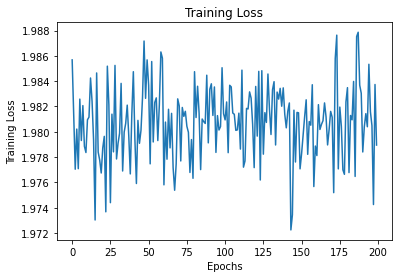

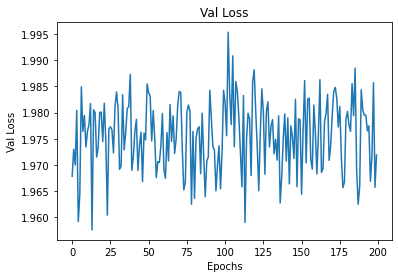

In [ ]:
plt.plot(range(len(light_train_loss)), light_train_loss)
plt.xlabel("Epochs")
plt.ylabel('Training Loss')
plt.title("Training Loss")
plt.show()

plt.plot(range(len(light_val_loss)), light_val_loss)
plt.xlabel("Epochs")
plt.ylabel('Val Loss')
plt.title("Val Loss")
plt.show()

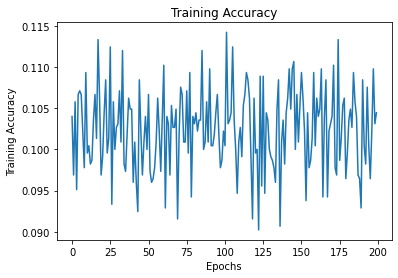

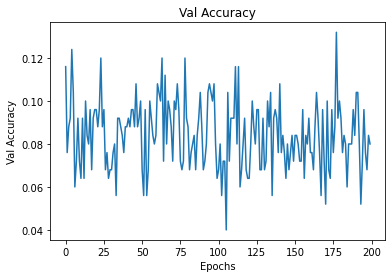

In [ ]:
plt.plot(range(len(light_acc_train)), light_acc_train)
plt.xlabel("Epochs")
plt.ylabel('Training Accuracy')
plt.title("Training Accuracy")
plt.show()

plt.plot(range(len(light_acc_val)), light_acc_val)
plt.xlabel("Epochs")
plt.ylabel('Val Accuracy')
plt.title("Val Accuracy")
plt.show()

## LightGCN Test

In [ ]:
def test():
  idx_test = list(range(2500, 2700))
  idx_test = torch.LongTensor(idx_test).cuda()
  LightGCN_model.eval()
  output = LightGCN_model(features,adj)
  loss_test = F.nll_loss(output[idx_test], labels[idx_test])
  acc_test = accuracy(output[idx_test], labels[idx_test])
  print("Light GCN Test set results:",
        "loss= {:.4f}".format(loss_test.item()),
        "accuracy= {:.4f}".format(acc_test.item()))
test()

Test set results: loss= 1.9017 accuracy= 0.3200


# ResGCN


## Load Dataset

In [ ]:
adj, features, labels = load_data()

## Parameter Setting

In [ ]:
parser = argparse.ArgumentParser()
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='Cuda Status')
parser.add_argument('--seed', type=int, default=42, help='Random seed.')
parser.add_argument('--epochs', type=int, default= 200,
                    help='Number of epochs.')
parser.add_argument('--lr', type=float, default=0.0001,
                    help='Learning rate')
parser.add_argument('--weight_decay', type=float, default=5e-4,
                    help='L2 norm')
parser.add_argument('--hidden', type=int, default=32,
                    help='Number of hidden nodes..')
parser.add_argument('--dropout', type=float, default=0.5,
                    help='Dropout rate')
args = parser.parse_args(args=[])

args.cuda = not args.no_cuda and torch.cuda.is_available()
np.random.seed(args.seed)
torch.manual_seed(args.seed)   
if args.cuda:
    torch.cuda.manual_seed(args.seed)

## Main Structure

In [ ]:
class basicblock(nn.Module):
  def __init__(
    self, 
    n_hidden, 
    dropout,
    adj): 
    super(basicblock, self).__init__() 
    self.layer1 = GraphConvolution(n_hidden, n_hidden)   
    self.layer2 = GraphConvolution(n_hidden, n_hidden)
    self.dropout = dropout
    self.adj = adj

  def forward(self, x):
    identity = x
    out = self.layer1(x, self.adj)
    out += identity
    out = F.relu(out) 
    #out = F.tanh(out)
    x = F.dropout(out, self.dropout)
    x = self.layer2(x, self.adj)
    
    return x

## Full Structure

In [ ]:
class ResGCN(nn.Module):
  def __init__(
      self, 
      n_blocks, 
      n_feature,
      n_hidden,
      n_class,
      dropout,
      adj):
      super(ResGCN, self).__init__()
      self.adj = adj
      self.layer1 = GraphConvolution(n_feature, n_hidden)  
      self.layer2 = GraphConvolution(n_hidden, n_hidden)   
      self.layer3 = GraphConvolution(n_hidden, n_class)  
      self.layers = Seq(*[basicblock(n_hidden, dropout, self.adj)
                            for _ in range(n_blocks-2)])
      # self.layer11 = basicblock(n_hidden, dropout)
      # self.layer12 = basicblock(n_hidden, dropout)
      # self.layer13 = basicblock(n_hidden, dropout)
      # self.layer14 = basicblock(n_hidden, dropout)
      # self.layer15 = basicblock(n_hidden, dropout)

  def forward(self, x):
      x = self.layer1(x, self.adj)
      x = F.relu(x)
      x = self.layer2(x, self.adj)
      x = self.layers(x)
      x = F.relu(x)
      x = self.layer3(x, self.adj)
      x = F.log_softmax(x)

      return x


In [ ]:
Res_model = ResGCN(
        n_blocks=3,
        n_feature=features.shape[1],
        n_hidden=args.hidden,
        n_class=labels.max().item() + 1,
        dropout=args.dropout,
        adj=adj)
optimizer = optim.Adam(Res_model.parameters(),lr=0.01,
                       weight_decay=args.weight_decay)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[30,80],gamma=0.1)
if args.cuda:
  Res_model.cuda()  
  features = features.cuda()
  adj = adj.cuda()
  labels = labels.cuda()


## ResGCN Training

In [ ]:
def ResGCN_train(epochs, optimizer, scheduler):
  # get index for train and val
  kf = KFold(n_splits=10,shuffle = True)
  index = list(range(2500))
  list_train_loss, list_acc_train, list_val_loss, list_acc_val = [], [], [], []
  for epoch in range(epochs):
    for idx_train, idx_val in kf.split(index):
      lst_loss_train, lst_acc_train, lst_acc_val, lst_loss_val =[],[],[],[] 
      idx_train = torch.LongTensor(idx_train).cuda()
      idx_val = torch.LongTensor(idx_val).cuda()

      Res_model.train()
      optimizer.zero_grad()
      output = Res_model(features)
      loss_train = F.nll_loss(output[idx_train], labels[idx_train])
      acc_train = accuracy(output[idx_train], labels[idx_train])
      # Back propogation
      loss_train.backward()  
      optimizer.step()  
      scheduler.step()  

      Res_model.eval()
      output = Res_model(features)
      loss_val = F.nll_loss(output[idx_val], labels[idx_val]) 
      acc_val = accuracy(output[idx_val], labels[idx_val])

      
      lst_acc_train.append(acc_train.item())
      lst_acc_val.append(acc_val.item())
      lst_loss_train.append(loss_train.item())
      lst_loss_val.append(loss_val.item())

     
    
    print('Epoch: {:04d}'.format(epoch+1),
          'loss_train: {:.4f}'.format(np.mean(lst_loss_train)),
          'acc_train: {:.4f}'.format(np.mean(lst_acc_train)),
          'loss_val: {:.4f}'.format(np.mean(lst_loss_val)),
          'acc_val: {:.4f}'.format(np.mean(lst_acc_val)))

    list_train_loss.append(np.mean(lst_loss_train))
    list_acc_train.append(np.mean(lst_acc_train))
    list_val_loss.append(np.mean(lst_loss_val))
    list_acc_val.append(np.mean(lst_acc_val))

  return list_train_loss, list_acc_train, list_val_loss, list_acc_val

In [ ]:
# res_train_loss, res_acc_train, res_val_loss, res_acc_val = [], [], [], []

res_train_loss, res_acc_train, res_val_loss, res_acc_val = ResGCN_train(400, optimizer, scheduler)
print("Optimization Finished!")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 0001 loss_train: 1.8338 acc_train: 0.3000 loss_val: 1.8298 acc_val: 0.3040
Epoch: 0002 loss_train: 1.7684 acc_train: 0.2987 loss_val: 1.7649 acc_val: 0.3160
Epoch: 0003 loss_train: 1.4968 acc_train: 0.3600 loss_val: 1.5542 acc_val: 0.3400
Epoch: 0004 loss_train: 1.4760 acc_train: 0.3782 loss_val: 1.3955 acc_val: 0.4280
Epoch: 0005 loss_train: 1.4483 acc_train: 0.3773 loss_val: 1.4439 acc_val: 0.3680
Epoch: 0006 loss_train: 1.4200 acc_train: 0.3818 loss_val: 1.4269 acc_val: 0.3640
Epoch: 0007 loss_train: 1.3959 acc_train: 0.4218 loss_val: 1.3531 acc_val: 0.4560
Epoch: 0008 loss_train: 1.3570 acc_train: 0.4431 loss_val: 1.4306 acc_val: 0.3760
Epoch: 0009 loss_train: 1.3704 acc_train: 0.4231 loss_val: 1.2761 acc_val: 0.5040
Epoch: 0010 loss_train: 1.3512 acc_train: 0.4458 loss_val: 1.3520 acc_val: 0.3920
Epoch: 0011 loss_train: 1.3448 acc_train: 0.4476 loss_val: 1.3922 acc_val: 0.4280
Epoch: 0012 loss_train: 1.3437 acc_train: 0.4600 loss_val: 1.3827 acc_val: 0.4640
Epoch: 0013 loss

## ResGCN Draw Out

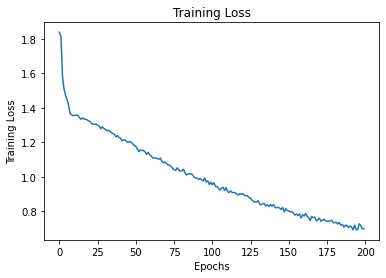

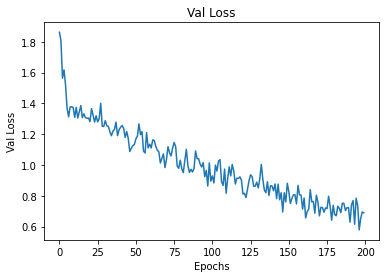

In [ ]:
plt.plot(range(len(res_train_loss)), res_train_loss)
plt.xlabel("Epochs")
plt.ylabel('Training Loss')
plt.title("Training Loss")
plt.show()

plt.plot(range(len(res_val_loss)), res_val_loss)
plt.xlabel("Epochs")
plt.ylabel('Val Loss')
plt.title("Val Loss")
plt.show()

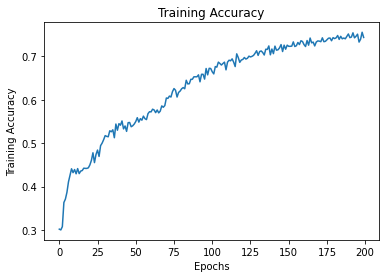

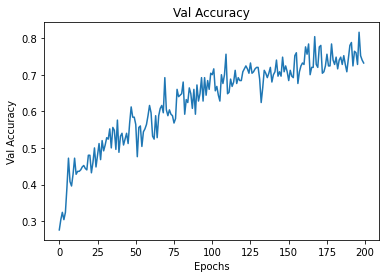

In [ ]:
plt.plot(range(len(res_acc_train)), res_acc_train)
plt.xlabel("Epochs")
plt.ylabel('Training Accuracy')
plt.title("Training Accuracy")
plt.show()

plt.plot(range(len(res_acc_val)), res_acc_val)
plt.xlabel("Epochs")
plt.ylabel('Val Accuracy')
plt.title("Val Accuracy")
plt.show()

## ResGCN Test 

In [ ]:
def test():
  idx_test = list(range(2500, 2700))
  idx_test = torch.LongTensor(idx_test).cuda()
  Res_model.eval()
  output = Res_model(features)
  loss_test = F.nll_loss(output[idx_test], labels[idx_test])
  acc_test = accuracy(output[idx_test], labels[idx_test])
  print("Test set results:",
        "loss= {:.4f}".format(loss_test.item()),
        "accuracy= {:.4f}".format(acc_test.item()))
test()

Test set results: loss= 1.3095 accuracy= 0.6650


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


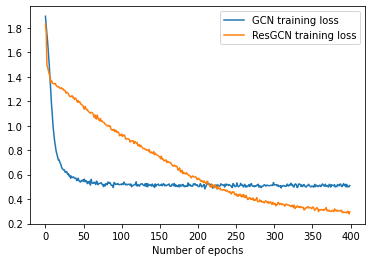

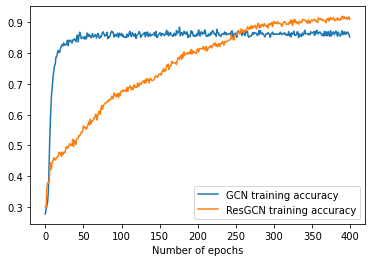

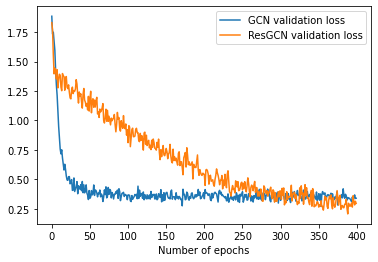

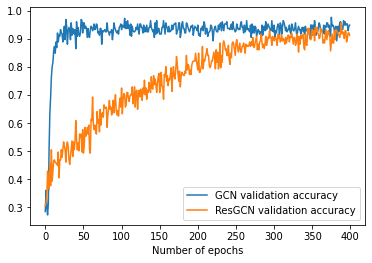

In [ ]:
plt.figure()
plt.plot(gcn_train_loss, label='GCN training loss')
plt.plot(res_train_loss, label='ResGCN training loss')
plt.xlabel('Number of epochs'); plt.legend()
plt.figure()
plt.plot(gcn_acc_train, label='GCN training accuracy')
plt.plot(res_acc_train, label='ResGCN training accuracy')
plt.xlabel('Number of epochs'); plt.legend()
plt.figure()
plt.plot(gcn_val_loss, label='GCN validation loss')
plt.plot(res_val_loss, label='ResGCN validation loss')
plt.xlabel('Number of epochs'); plt.legend()
plt.figure()
plt.plot(gcn_acc_val, label='GCN validation accuracy')
plt.plot(res_acc_val, label='ResGCN validation accuracy')
plt.xlabel('Number of epochs'); plt.legend()
plt.show()